# Log Analysis
BGLデータセット('https://github.com/logpai/loghub/tree/master/BGL')を利用して、ログ解析(アノマリ検知)を行う。

### Import

In [1]:
import sys
import os
import pandas as pd
import datetime
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
from data_preprocessing import DataPreprocessing, FeatureExtraction, CreateLabel_BGL, RelatedInfo

### Config

In [2]:
class Config:
    resource_name = "BGL"
    log_data_path = "./data/" + resource_name + "/" + resource_name + "_2k.log"
    feedback_ratio = 0.05
    train_size = 0.8
    th = 0.75
    n_splits = 5
config = Config

### Get Data

In [3]:
with open(config.log_data_path, "r") as f:
    log_data = pd.DataFrame({"log": f.readlines()})
display(log_data)

,log
0,- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 20...
1,- 1117838573 2005.06.03 R02-M1-N0-C:J12-U11 20...
2,- 1117838976 2005.06.03 R02-M1-N0-C:J12-U11 20...
3,- 1117838978 2005.06.03 R02-M1-N0-C:J12-U11 20...
4,- 1117842440 2005.06.03 R23-M0-NE-C:J05-U01 20...
...,...
1995,- 1135665476 2005.12.26 R37-M1-NC-C:J02-U11 20...
1996,- 1135669430 2005.12.26 R37-M1-NC-C:J02-U11 20...
1997,- 1135669517 2005.12.26 R37-M1-NC-C:J02-U11 20...
1998,- 1135675498 2005.12.27 R37-M1-NC-C:J02-U11 20...


In [4]:
log_data_list = []
for i in range(log_data.shape[0]):
    L = str(log_data.values[i][0]).split()
    message_time = L[4][:-7]
    message_time = datetime.datetime.strptime(message_time, '%Y-%m-%d-%H.%M.%S')
    message = " ".join(L[6:])
    if L[0]=="-":
        label=0
        category = L[0]
    else:
        label=1
        category = L[0]
    log_data_list.append([message_time, message, label, category])
data = pd.DataFrame(log_data_list, columns=["message_time", "message", "label", "category"])
display(data)

,message_time,message,label,category
0,2005-06-03 15:42:50,RAS KERNEL INFO instruction cache parity error...,0,-
1,2005-06-03 15:42:53,RAS KERNEL INFO instruction cache parity error...,0,-
2,2005-06-03 15:49:36,RAS KERNEL INFO instruction cache parity error...,0,-
3,2005-06-03 15:49:38,RAS KERNEL INFO instruction cache parity error...,0,-
4,2005-06-03 16:47:20,RAS KERNEL INFO 63543 double-hummer alignment ...,0,-
...,...,...,...,...
1995,2005-12-26 22:37:56,RAS KERNEL INFO instruction cache parity error...,0,-
1996,2005-12-26 23:43:50,RAS KERNEL INFO instruction cache parity error...,0,-
1997,2005-12-26 23:45:17,RAS KERNEL INFO instruction cache parity error...,0,-
1998,2005-12-27 01:24:58,RAS KERNEL INFO instruction cache parity error...,0,-


### EDA

In [5]:
data_info = data.groupby(["category"]).size()
display(pd.DataFrame(data_info,columns=["件数"]))

,件数
category,
-,1857
APPCHILD,1
APPOUT,1
APPREAD,3
APPRES,4
APPSEV,17
APPTO,2
KERNDTLB,60
KERNMNTF,11


### Split Data

In [6]:
# 正常/異常データの分割
normal_data = data[data["label"]==0].reset_index(drop=True)
anomaly_data = data[data["label"]==1].reset_index(drop=True)
# feedbackデータと異常データの分割(feedbackのlabelは-1とする)
extract_index = random.sample(range(anomaly_data.shape[0]), k=int(anomaly_data.shape[0] * config.feedback_ratio))
feedback = anomaly_data.iloc[extract_index,:].reset_index(drop=True)
feedback["label"] = -1
anomaly_data = anomaly_data.drop(extract_index).reset_index(drop=True)
# 学習/推論データに分割
data_tmp = pd.concat([normal_data, anomaly_data])
train, test = train_test_split(data_tmp, train_size=config.train_size, shuffle=True, random_state=1)
train = train.sort_values("message_time").reset_index(drop=True)
test = test.sort_values("message_time").reset_index(drop=True)
# 表示
display(train.head())
display(test.head())
display(feedback.head())

,message_time,message,label,category
0,2005-06-03 15:42:53,RAS KERNEL INFO instruction cache parity error...,0,-
1,2005-06-03 15:49:36,RAS KERNEL INFO instruction cache parity error...,0,-
2,2005-06-03 16:47:20,RAS KERNEL INFO 63543 double-hummer alignment ...,0,-
3,2005-06-03 16:56:14,RAS KERNEL INFO 162 double-hummer alignment ex...,0,-
4,2005-06-03 16:56:55,RAS KERNEL INFO 141 double-hummer alignment ex...,0,-


,message_time,message,label,category
0,2005-06-03 15:42:50,RAS KERNEL INFO instruction cache parity error...,0,-
1,2005-06-03 15:49:38,RAS KERNEL INFO instruction cache parity error...,0,-
2,2005-06-04 20:28:40,"RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask...",0,-
3,2005-06-05 00:36:20,RAS KERNEL INFO generating core.728,0,-
4,2005-06-05 05:16:26,RAS KERNEL INFO generating core.1414,0,-


,message_time,message,label,category
0,2005-09-02 12:40:43,RAS KERNEL FATAL Lustre mount FAILED : bglio46...,-1,KERNMNTF
1,2005-06-11 17:42:39,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB
2,2005-06-13 17:41:21,RAS KERNEL FATAL data storage interrupt,-1,KERNSTOR
3,2005-06-11 19:33:03,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB
4,2005-06-11 17:46:52,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB


### remove parameter

In [7]:
feedback["message_after"] = DataPreprocessing(feedback["message"].values)()
train["message_after"] = DataPreprocessing(train["message"].values)()
test["message_after"] = DataPreprocessing(test["message"].values)()
display(train.head())
display(test.head())
display(feedback.head())

,message_time,message,label,category,message_after
0,2005-06-03 15:42:53,RAS KERNEL INFO instruction cache parity error...,0,-,RAS KERNEL INFO instruction cache parity error...
1,2005-06-03 15:49:36,RAS KERNEL INFO instruction cache parity error...,0,-,RAS KERNEL INFO instruction cache parity error...
2,2005-06-03 16:47:20,RAS KERNEL INFO 63543 double-hummer alignment ...,0,-,RAS KERNEL INFO double hummer alignment except...
3,2005-06-03 16:56:14,RAS KERNEL INFO 162 double-hummer alignment ex...,0,-,RAS KERNEL INFO double hummer alignment except...
4,2005-06-03 16:56:55,RAS KERNEL INFO 141 double-hummer alignment ex...,0,-,RAS KERNEL INFO double hummer alignment except...


,message_time,message,label,category,message_after
0,2005-06-03 15:42:50,RAS KERNEL INFO instruction cache parity error...,0,-,RAS KERNEL INFO instruction cache parity error...
1,2005-06-03 15:49:38,RAS KERNEL INFO instruction cache parity error...,0,-,RAS KERNEL INFO instruction cache parity error...
2,2005-06-04 20:28:40,"RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask...",0,-,RAS KERNEL INFO CE sym at mask
3,2005-06-05 00:36:20,RAS KERNEL INFO generating core.728,0,-,RAS KERNEL INFO generating core
4,2005-06-05 05:16:26,RAS KERNEL INFO generating core.1414,0,-,RAS KERNEL INFO generating core


,message_time,message,label,category,message_after
0,2005-09-02 12:40:43,RAS KERNEL FATAL Lustre mount FAILED : bglio46...,-1,KERNMNTF,RAS KERNEL FATAL Lustre mount FAILED point p
1,2005-06-11 17:42:39,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB,RAS KERNEL FATAL data TLB error interrupt
2,2005-06-13 17:41:21,RAS KERNEL FATAL data storage interrupt,-1,KERNSTOR,RAS KERNEL FATAL data storage interrupt
3,2005-06-11 19:33:03,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB,RAS KERNEL FATAL data TLB error interrupt
4,2005-06-11 17:46:52,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB,RAS KERNEL FATAL data TLB error interrupt


### feature extraction

In [8]:
train_all = pd.concat([train, feedback]).reset_index(drop=True)
train_feature, vocabulary = FeatureExtraction(train_all["message_after"].values, mode="train", fe_type="tfilf")()
test_feature, _ = FeatureExtraction(test["message_after"].values, mode="test", fe_type="tfilf")()
train_feature = pd.concat([train_feature, train_all["label"]], axis=1)
test_feature = pd.concat([test_feature, test["label"]], axis=1)
display(train_feature.head())
display(test_feature.head())

,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,label
0,7.368433,7.368433,7.368433,6.276444,6.680249,6.680249,5.074799,5.766948,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,7.368433,7.368433,7.368433,6.276444,6.680249,6.680249,5.074799,5.766948,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,label
0,5.979011,5.979011,5.979011,5.290827,5.979011,5.290827,4.377526,4.887021,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.979011,5.979011,5.979011,5.290827,5.979011,5.290827,4.377526,4.887021,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Create Label
trainデータのlabelをfeedbackデータ(label=-1のデータ)を基にコサイン類似度から生成する。

In [9]:
train_feature = CreateLabel_BGL(train_all, train_feature, config.th)()
display(train_feature.head(10))

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,label,category,category_pred,related,use_label
0,7.368433,7.368433,7.368433,6.276444,6.680249,6.680249,5.074799,5.766948,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.398981,0
1,7.368433,7.368433,7.368433,6.276444,6.680249,6.680249,5.074799,5.766948,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.398981,0
2,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.331377,0
3,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.331377,0
4,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,7.368433,7.368433,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.331377,0
5,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.327024,0
6,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1,APPREAD,APPREAD,1.000000,1
7,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.392922,0
8,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.392922,0
9,7.368433,7.368433,7.368433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,-,normal,0.392922,0


### Train

In [10]:
params = {"max_length": [5,8,10]}
clf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=config.n_splits), scoring="recall_macro")
model = clf.fit(train_feature.iloc[:,:-5].values, train_feature["use_label"].values) # TF-ILFで特徴量抽出したデータでモデル生成

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length


### Top10 Keyword

In [11]:
keyword = pd.DataFrame({"word": vocabulary.keys(), "importance":model.best_estimator_.feature_importances_})
keyword = keyword.sort_values("importance", ascending=False)
display(keyword.head(10))

,word,importance
46,data,150
70,point,78
1,KERNEL,73
17,FATAL,66
69,floating,64
20,to,63
48,interrupt,61
49,storage,47
50,address,45
47,TLB,45


### Train Score
本来の異常とのスコアを算出

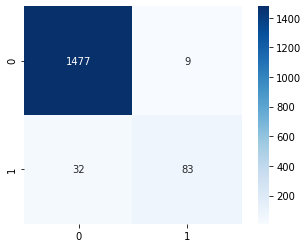

,precision,recall,f1-score,support
0,0.978794,0.993943,0.986311,1486.000000
1,0.902174,0.721739,0.801932,115.000000
accuracy,0.974391,0.974391,0.974391,0.974391
macro avg,0.940484,0.857841,0.894121,1601.000000
weighted avg,0.973290,0.974391,0.973067,1601.000000


In [12]:
y_true = train_feature["label"].apply(lambda x : 1 if x == -1 else x).values
y_pred = model.predict(train_feature.iloc[:,:-5].values)
# scoring
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Test

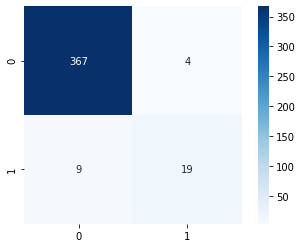

,precision,recall,f1-score,support
0,0.976064,0.989218,0.982597,371.000000
1,0.826087,0.678571,0.745098,28.000000
accuracy,0.967419,0.967419,0.967419,0.967419
macro avg,0.901075,0.833895,0.863848,399.000000
weighted avg,0.965539,0.967419,0.965930,399.000000


In [13]:
test_feature["y_pred"] = model.predict(test_feature.iloc[:,:-1].values)
# scoring
cm = confusion_matrix(test_feature["label"], test_feature["y_pred"])
classification_result = pd.DataFrame(classification_report(test_feature["label"], test_feature["y_pred"], output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Visualize Log

In [14]:
all_proba = RelatedInfo(test_feature, train_feature)()
result = pd.concat([test[["message_time", "message","label"]], all_proba], axis=1)
result = result.rename(columns={"label":"【参考】本来のlabel"})
result = result[["message_time", "message", "正常(0)/異常(1)", "関連する過去の障害", "関連度(%)", "【参考】本来のlabel"]]

In [15]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
result.style.apply(highlight_greaterthan, threshold=1.0, column=['正常(0)/異常(1)'], axis=1)

,message_time,message,正常(0)/異常(1),関連する過去の障害,関連度(%),【参考】本来のlabel
0,2005-06-03 15:42:50,RAS KERNEL INFO instruction cache parity error corrected,0,-,-,0
1,2005-06-03 15:49:38,RAS KERNEL INFO instruction cache parity error corrected,0,-,-,0
2,2005-06-04 20:28:40,"RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask 0x40",0,-,-,0
3,2005-06-05 00:36:20,RAS KERNEL INFO generating core.728,0,-,-,0
4,2005-06-05 05:16:26,RAS KERNEL INFO generating core.1414,0,-,-,0
5,2005-06-05 09:18:06,RAS KERNEL INFO generating core.5854,0,-,-,0
6,2005-06-05 10:01:26,RAS KERNEL INFO generating core.6801,0,-,-,0
7,2005-06-05 10:02:31,RAS KERNEL INFO generating core.4368,0,-,-,0
8,2005-06-05 10:03:00,RAS KERNEL INFO generating core.851,0,-,-,0
9,2005-06-05 10:29:13,RAS KERNEL INFO generating core.7192,0,-,-,0


In [16]:
test_feature

,0,1,2,3,4,5,6,7,8,9,...,438,439,440,441,442,443,444,445,label,y_pred
0,5.979011,5.979011,5.979011,5.290827,5.979011,5.290827,4.377526,4.887021,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,5.979011,5.979011,5.979011,5.290827,5.979011,5.290827,4.377526,4.887021,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,5.979011,5.979011,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
395,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
396,5.979011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
397,5.979011,5.979011,5.979011,5.290827,5.979011,5.290827,4.377526,4.887021,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
